<a href="https://colab.research.google.com/github/natrask/ENM5310/blob/main/DNN_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!/usr/bin/env python
# coding: utf-8
# In[91]:
import numpy as np
import scipy
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.reset_default_graph()
config = tf.ConfigProto()
sess = tf.Session(config=config)

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
meshsize= 5
h = 1./float(meshsize-1)
points = np.linspace(0,1,meshsize)

Some helper functions to evaluate tent functions and their derivatives.

In [ ]:
def evalPhi_i(x):
    return tf.nn.relu(1.0-(tf.abs(tf.expand_dims(x,0)-tf.expand_dims(points,1)))/h)

def evalGradPhi_i(x):
    suppPhi = tf.cast(evalPhi_i(x)>0,tf.float64)
    signPlus = tf.cast(tf.expand_dims(points,1) > tf.expand_dims(x,0),tf.float64)
    signNeg = tf.cast(tf.expand_dims(points,1) <= tf.expand_dims(x,0),tf.float64)
    return suppPhi*(-signPlus+signNeg)/h

Build up set of quadrature points, evaluate mass and stiffness matrices. Note that we were careful to use a quadrature rule that doesn't evaluate the derivative where it is undefined.

In [ ]:
# %% Get mass matrices
xql = points[:-1]+h*(0.5+1./(2.*np.sqrt(3)))
xqr = points[:-1]+h*(0.5-1./(2.*np.sqrt(3)))
xq = np.sort(np.concatenate([xql,xqr],axis=0))

#mass matrix of P1 basis functions
nodal_basisEval = evalPhi_i(xq)
Mnodal=(h/2.)*tf.reduce_sum(tf.expand_dims(nodal_basisEval,0)*tf.expand_dims(nodal_basisEval,1),axis=2)

#stiffness matrix of P1 basis functions
nodal_gradbasisEval = evalGradPhi_i(xq)
Snodal=(h/2.)*tf.reduce_sum(tf.expand_dims(nodal_gradbasisEval,0)*tf.expand_dims(nodal_gradbasisEval,1),axis=2)

In [ ]:
#Verify correct implementation by integrating checking vol(\Omega)= 1^T M 1
sess.run(tf.einsum('i,ij,j',np.ones(meshsize),Mnodal,np.ones(meshsize)))

1.0

Visualize shape functions.

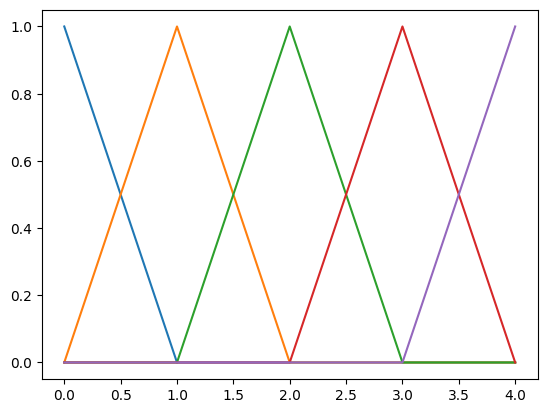

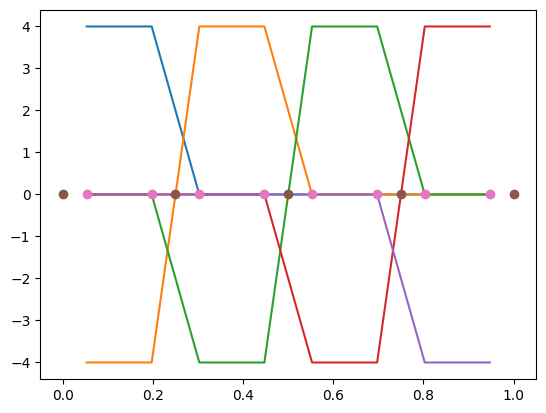

In [ ]:
plt.figure()
plt.plot(sess.run(evalPhi_i(points)).T)
plt.figure()
plt.plot(xq,sess.run(evalGradPhi_i(xq)).T)
plt.plot(points,np.zeros(meshsize),'o')
plt.plot(xq,np.zeros(2*(meshsize-1)),'o')

In [ ]:
projForcing = tf.einsum('ij,j->i',Mnodal,np.ones(meshsize))
solution_mat = tf.concat([tf.expand_dims(tf.one_hot(0,meshsize,dtype=tf.float64),0),
 Snodal[1:meshsize-1,:],
 tf.expand_dims(tf.one_hot(meshsize-1,meshsize,dtype=tf.float64),0)],
          axis=0)
solution_rhs = tf.concat([tf.zeros((1,),dtype=tf.float64),
                          projForcing[1:meshsize-1],
                 tf.zeros((1,),dtype=tf.float64)],axis=0)

u_sol = sess.run(tf.linalg.solve(solution_mat,tf.expand_dims(solution_rhs,1)))

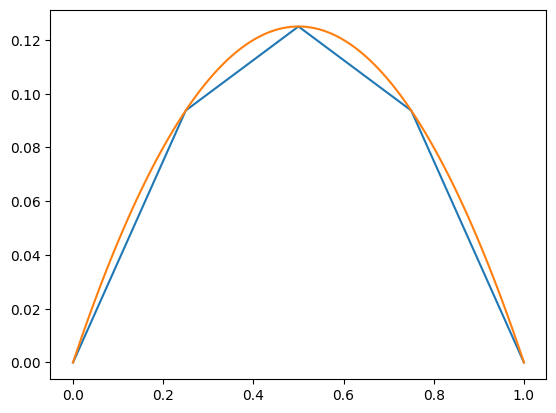

In [ ]:
plt.figure()
plt.plot(points,u_sol)
xtrue = np.linspace(0,1,100)
plt.plot(xtrue,0.5*xtrue*(1.-xtrue))